# 1.  Import data and libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
caminho_arquivo = '../data/raw/Metro_Interstate_Traffic_Volume.csv'
df = pd.read_csv(caminho_arquivo)

# 2. Basic informations about the dataset

In [2]:
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,NaN,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,NaN,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,NaN,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,NaN,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,NaN,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


Please note that observations are made on an hourly basis, capturing real-time details such as temperature, precipitation, and weather conditions, with the primary metric being traffic volume.

## Shape (number of rows and columns)

In [3]:
print("\nDataset dimensions (rows, columns):")
df.shape


Dataset dimensions (rows, columns):


(48204, 9)

## Technical Informations

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     str    
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  str    
 6   weather_description  48204 non-null  str    
 7   date_time            48204 non-null  str    
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), str(4)
memory usage: 3.3 MB


Note that the 'holiday' column only contains 61 non-null values because only a minority of days are holidays.  

## Analysis of Temporal Gaps

In [5]:
# --- Prepare data of date time ---

# Convert the column 'date_time' to the datetime format of pandas
# Essential for any time series analysis
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index of the DataFrame to make it easier to work with time series data
df = df.set_index('date_time')

# Sort the index to ensure the data is in chronological order
df = df.sort_index()

# Show the start and end of the data to confirm the period
print(f"Start date: {df.index.min()}")
print(f"End date: {df.index.max()}")
print(f"Total records: {len(df)}")


Start date: 2012-10-02 09:00:00
End date: 2018-09-30 23:00:00
Total records: 48204


So, observing the start and end date of the observations, we see that, in fact, the data was collected from October 2012 to September 2018.

# 3. Investigate Missing Values

### But, before we need to remove duplicates

To resolve duplicate data, I used two aggregation rules:

* Rule for numerical data: mean
* Rule for categorical data: first occurrence

In [6]:

# Check how many duplicates exist
print(f"Number of duplicate rows (by index): {df.index.duplicated().sum()}")

# --- Handle Conflicting Duplicate Timestamps ---

# 1. Define which columns are numeric and which are categorical
#    (Note: 'traffic_volume' is treated as numeric for aggregation)
numeric_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
categorical_cols = ['holiday', 'weather_main', 'weather_description']

# 2. Create a dictionary of aggregation rules
agg_rules = {}

# Rule for numeric: take the mean
for col in numeric_cols:
    agg_rules[col] = 'mean'

# Rule for categorical: take the first occurrence
for col in categorical_cols:
    agg_rules[col] = 'first'

print("Aggregation rules defined:")
print(agg_rules)
print("-" * 60)

# 3. Group by the index (timestamp) and apply the aggregation rules
#    This will merge all rows with the same timestamp into one.
df_aggregated = df.groupby(df.index).agg(agg_rules)

# 4. Check the results
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after aggregation: {len(df_aggregated)}")
print(f"Number of duplicate timestamps now: {df_aggregated.index.duplicated().sum()}")

# Now, use this df_aggregated for your analysis
df = df_aggregated.copy()

Number of duplicate rows (by index): 7629
Aggregation rules defined:
{'temp': 'mean', 'rain_1h': 'mean', 'snow_1h': 'mean', 'clouds_all': 'mean', 'traffic_volume': 'mean', 'holiday': 'first', 'weather_main': 'first', 'weather_description': 'first'}
------------------------------------------------------------
Original number of rows: 48204
Number of rows after aggregation: 40575
Number of duplicate timestamps now: 0


### Find the missing values

In [7]:

# 1. Create an ideal date index, with hourly frequency ('h'),
#    from the first date to the last date recorded in your dataset.
start_date = df.index.min()
end_date = df.index.max()

# 'h' means 'hourly' frequency
ideal_index = pd.date_range(start=start_date, end=end_date, freq='h')

# Print a summary comparing the ideal index with the actual DataFrame index
print(f"Expected records (hourly): {len(ideal_index)}")
print(f"Existing records: {len(df)}")
print(f"Total missing hours: {len(ideal_index) - len(df)}")
print("-" * 60)

# 2. Find out which dates/times are in the ideal index but not in the index of your DataFrame
missing_dates = ideal_index.difference(df.index)

if missing_dates.empty:
    print("No missing time intervals found!")
else:
    print("MISSING FACTS: The following time intervals are missing from the dataset:")
    print(missing_dates)

print(f"\nTotal missing time intervals: {len(missing_dates)}")

Expected records (hourly): 52551
Existing records: 40575
Total missing hours: 11976
------------------------------------------------------------
MISSING FACTS: The following time intervals are missing from the dataset:
DatetimeIndex(['2012-10-03 07:00:00', '2012-10-03 10:00:00',
               '2012-10-03 11:00:00', '2012-10-03 17:00:00',
               '2012-10-05 02:00:00', '2012-10-05 04:00:00',
               '2012-10-06 03:00:00', '2012-10-07 01:00:00',
               '2012-10-07 02:00:00', '2012-10-09 03:00:00',
               ...
               '2018-03-24 05:00:00', '2018-03-24 06:00:00',
               '2018-03-24 07:00:00', '2018-03-29 02:00:00',
               '2018-05-05 02:00:00', '2018-06-02 02:00:00',
               '2018-08-07 07:00:00', '2018-08-07 08:00:00',
               '2018-08-07 09:00:00', '2018-08-23 02:00:00'],
              dtype='datetime64[us]', length=11976, freq=None)

Total missing time intervals: 11976


There are 11,976 missing time intervals, and now we need to understand why this is happening. Maybe there is some pattern that explains the lack of observations.

### Investigate to Find Patterns 

Initially, I have three possible hypothesis to answer this lack of observations: 

1. Is the data collected only by the day?
2. Isn't the data collected at weekends?
3. Did the sensor break for long times (months or years)?

Let's answer these questions below.

#### Check for patterns by hour

Distribution of missing data by hour of the day (0-23):
0     466
1     479
2     492
3     520
4     486
5     504
6     506
7     517
8     500
9     551
10    485
11    523
12    498
13    517
14    493
15    527
16    483
17    526
18    508
19    507
20    481
21    486
22    471
23    450
Name: count, dtype: int64


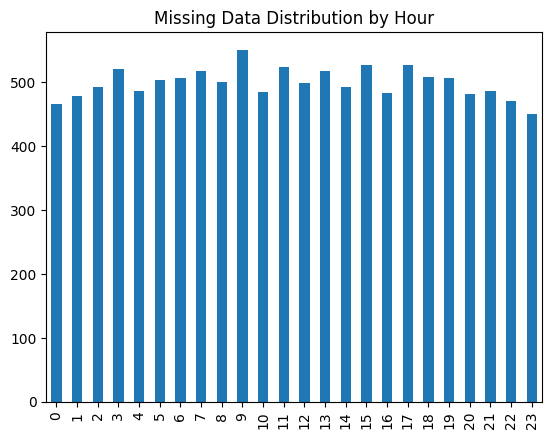

In [8]:
# Count how many times each HOUR of the day is missing
missing_hours_distribution = missing_dates.hour.value_counts().sort_index()
print("Distribution of missing data by hour of the day (0-23):")
print(missing_hours_distribution)

# You might want to plot this to see it better
import matplotlib.pyplot as plt
missing_hours_distribution.plot(kind='bar', title='Missing Data Distribution by Hour')
plt.show()

There is no patterns in missing values by hour

#### Check for patterns by the day of the week

In [9]:
# Count how many times each DAY OF THE WEEK is missing
# (0 = Monday, 6 = Sunday)
missing_dayofweek_distribution = missing_dates.dayofweek.value_counts().sort_index()
print("\nDistribution of missing data by day of the week (0=Mon, 6=Sun):")
print(missing_dayofweek_distribution)


Distribution of missing data by day of the week (0=Mon, 6=Sun):
0    1689
1    1800
2    1709
3    1715
4    1635
5    1728
6    1700
Name: count, dtype: int64


There is no patterns of missing values by the day of the week

#### Check for patterns by year


Distribution of missing data by Year-Month:
Year  Month
2012  10        44
      11        14
      12        14
2013  1        139
      2         78
              ... 
2018  1          2
      3         11
      5          1
      6          1
      8          4
Length: 63, dtype: int64


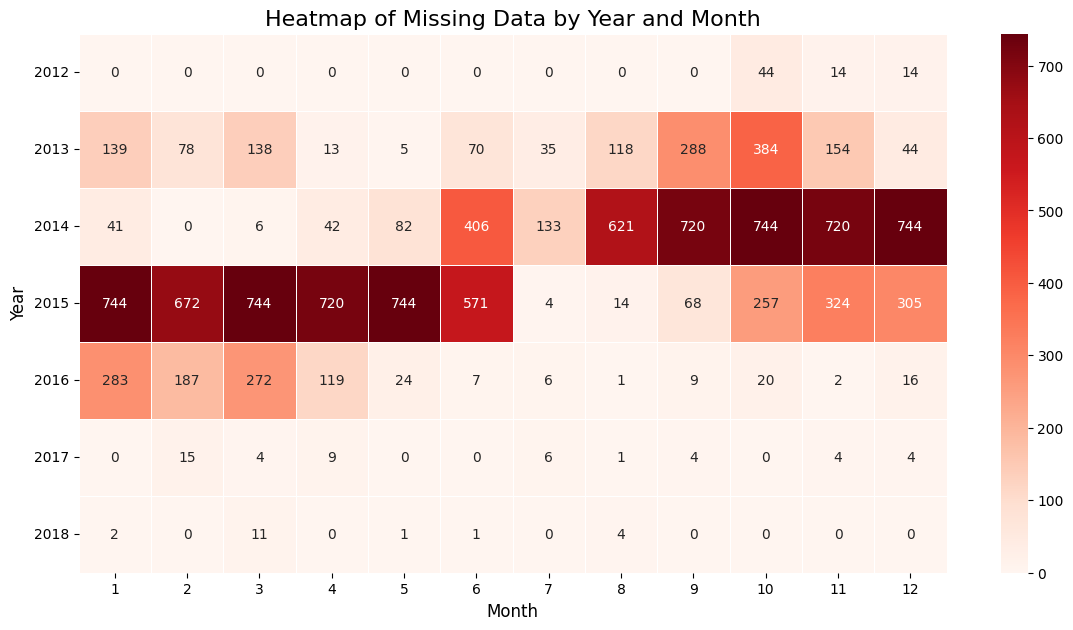

In [10]:
# Convert the DatetimeIndex to a Series to use .groupby()
missing_series = missing_dates.to_series()

# Group by both the year and the month of the index, then count the size of each group
missing_year_month_distribution = missing_series.groupby(
    [missing_series.index.year, missing_series.index.month]
).count()

# Rename the axes for clarity
missing_year_month_distribution.index.names = ['Year', 'Month']

print("\nDistribution of missing data by Year-Month:")
print(missing_year_month_distribution)

import matplotlib.pyplot as plt
import seaborn as sns

# Your data from the previous step (assuming it's named 'missing_year_month_distribution')
# missing_year_month_distribution = ...

# --- Plotting Code ---

# 1. Reshape the data for the heatmap
# We need to "unstack" the MultiIndex. We'll put 'Month' on the columns.
# .fillna(0) is important, as it fills in months that had 0 missing values.
try:
    data_heatmap = missing_year_month_distribution.unstack(level='Month').fillna(0)
    
    # 2. Create the plot
    plt.figure(figsize=(14, 7)) # Make the figure wider to fit 12 months
    
    # 3. Draw the heatmap
    sns.heatmap(
        data_heatmap, 
        annot=True,     # Show the numbers in each cell
        fmt=".0f",      # Format the numbers as integers (no decimals)
        cmap='Reds',    # Use a color scale from light to dark red
        linewidths=.5     # Add thin lines between cells
    )
    
    plt.title('Heatmap of Missing Data by Year and Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.yticks(rotation=0) # Ensure Y-axis (Year) labels are horizontal
    
    plt.show()
    plt.close()

except Exception as e:
    print(f"An error occurred while creating the heatmap: {e}")
    print("This can happen if 'missing_year_month_distribution' is empty.")


So it is evident that the period 08/2014 - 06/2015 has several missing timestamps.

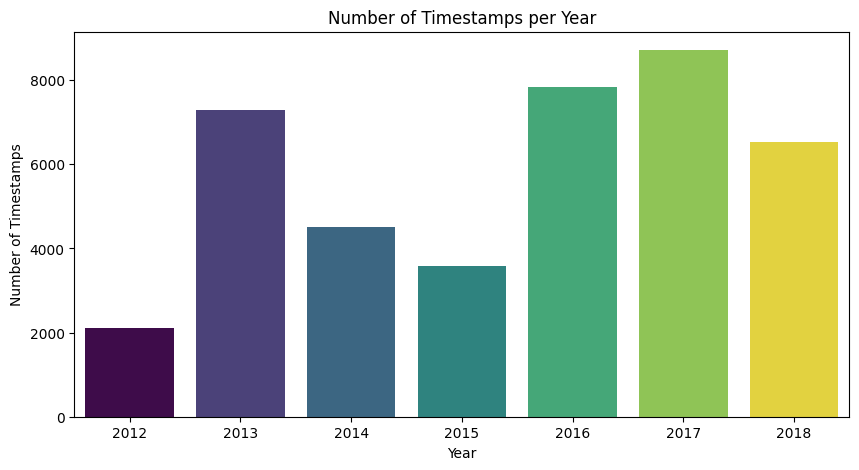

In [11]:
# analysing distribution of number of timestamps by year
timestamps_per_year = df.index.year.value_counts().sort_index()

# plotting the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=timestamps_per_year.index, y=timestamps_per_year.values, hue=timestamps_per_year.index, palette='viridis', legend=False)
plt.title('Number of Timestamps per Year')
plt.xlabel('Year')
plt.ylabel('Number of Timestamps')
plt.show()


### CRITICAL CHOICE: Drop or Impute timestamps in the period 08/2014 - 06/2015?

Given that the period with many missing observations is extensive (almost an entire year), the best approach would be to 
discard this data rather than attempting to impute it. Imputation could introduce significant biases, especially if traffic patterns during that period were different from other periods. 

Furthermore, not removing the data from this period breaks temporal continuity, which is crucial for time series analyses. Therefore, the most prudent decision is to eliminate these observations to maintain the integrity and reliability of subsequent analysis.

#### Decision: Drop timestamps from 08/2014 - 06/ (it will be done in the next notebook)

### Another question: Do the others timestamps at other periods with many missing observations need to be dropped too?

There are another periods with several (> 20%) missing timestamps, some of them are:

- 08/2013 (384 missing timestamps)
- 06/2014 (406 missing timestamps)
- 11/2015 (324 missing timestamps)
- 12/2015 (305 missing timestamps)
- 09/2013 (288 missing timestamps)

To check if these periods need to be dropped too, we want to plot the timestamps for these months and see if there is a large continuous gap or if the gaps are small and spaced out. If the failures are scattered, we can do seasonal imputation. Otherwise, the density of missing data and the continuity of the gaps prevent reliable imputation without introducing "significant synthetic bias".

### Now, we will automatically identify what months need to be dropped based on the criteria of having more than 20% of missing timestamps and plot them to visually inspect the gaps. 

But, the months at the critical period (08/2014 - 06/2015) will not be considered, since we already decided to drop this entire period.

In [12]:
# 1. Re-calculate missing dates after aggregation
ideal_index_agg = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_dates_agg = ideal_index_agg.difference(df.index)

# 2. Group missing dates by Year-Month
missing_series_agg = missing_dates_agg.to_series()
missing_by_month = missing_series_agg.groupby([missing_series_agg.index.year, missing_series_agg.index.month]).count()
missing_by_month.index.names = ['Year', 'Month']

# 3. Calculate total possible hours in each month
total_hours_per_month = ideal_index_agg.to_series().groupby([ideal_index_agg.year, ideal_index_agg.month]).count()
total_hours_per_month.index.names = ['Year', 'Month']

# 4. Calculate the percentage of missing data
missing_percentage = (missing_by_month / total_hours_per_month) * 100
missing_percentage = missing_percentage.rename('Missing_Pct')

# 5. Define the critical period to exclude
critical_period_start = '2014-08'
critical_period_end = '2015-06'

# Create a boolean mask for rows outside the critical period
outside_critical_period_mask = ~missing_percentage.index.map(
    lambda ym: (critical_period_start <= f"{ym[0]}-{ym[1]:02d}" <= critical_period_end)
)

# 6. Identify months to drop (outside critical period and > 20% missing)
months_to_investigate = missing_percentage[outside_critical_period_mask & (missing_percentage > 20)]

print("Months with >20% missing data (excluding critical period 08/2014-06/2015):")
print(months_to_investigate)

Months with >20% missing data (excluding critical period 08/2014-06/2015):
Year  Month
2013  9        40.000000
      10       51.612903
      11       21.388889
2014  6        56.388889
2015  10       34.543011
      11       45.000000
      12       40.994624
2016  1        38.037634
      2        26.867816
      3        36.559140
Name: Missing_Pct, dtype: float64


### Now, we can plot the periods with many missing timestamps


--- Plotting Gaps for Months to Investigate ---
--- Analyzing: 2013-09 ---
Missing hours: 288 (40.00%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2013_09.png


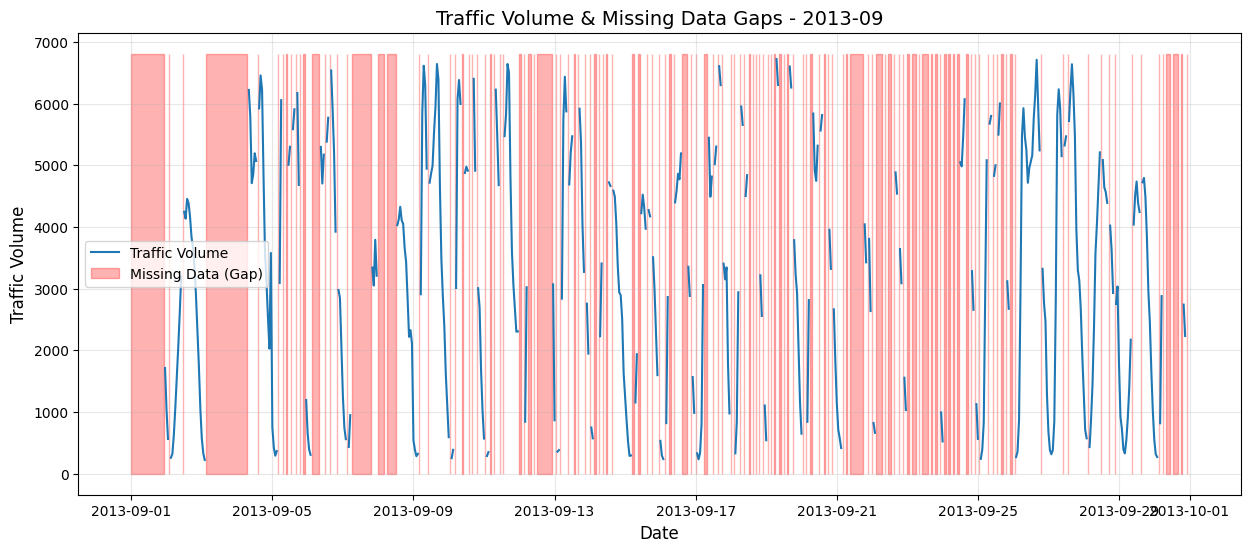

--- Analyzing: 2013-10 ---
Missing hours: 384 (51.61%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2013_10.png


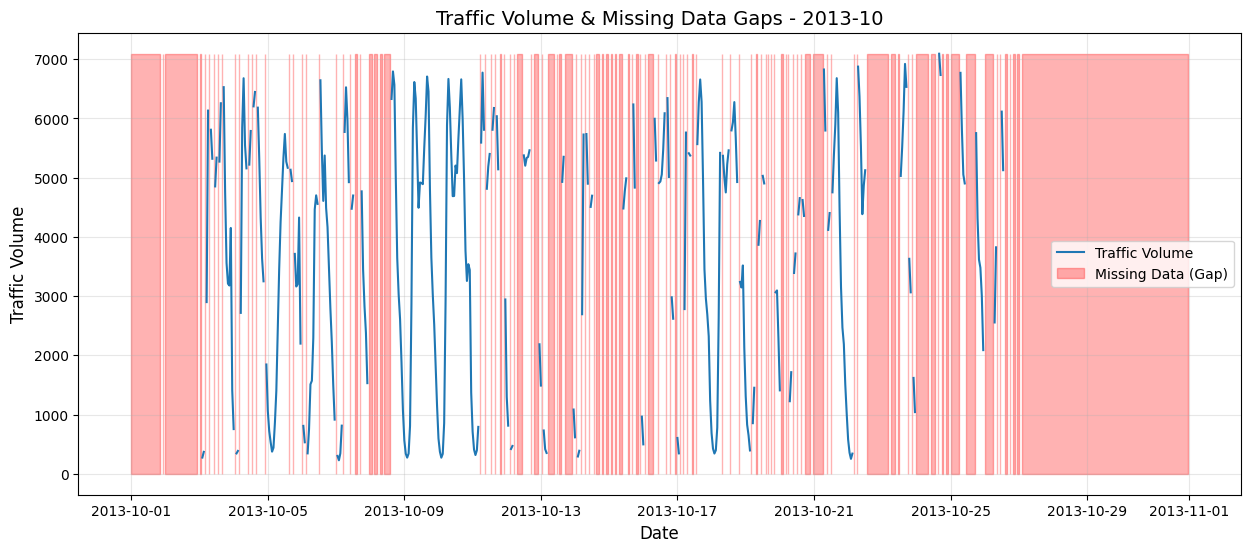

--- Analyzing: 2013-11 ---
Missing hours: 154 (21.39%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2013_11.png


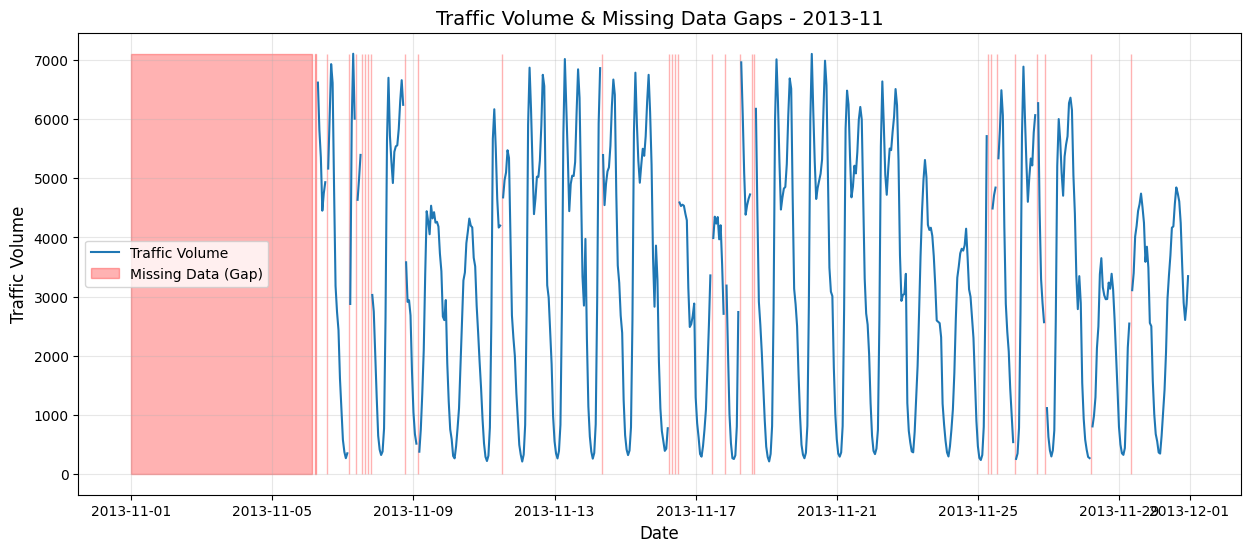

--- Analyzing: 2014-06 ---
Missing hours: 406 (56.39%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2014_06.png


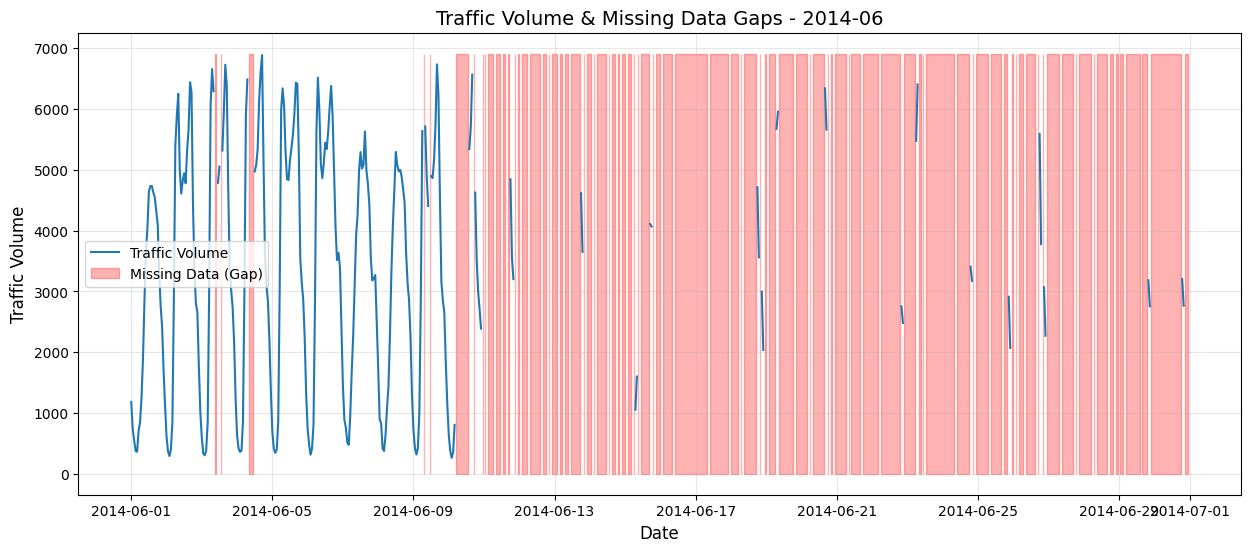

--- Analyzing: 2015-10 ---
Missing hours: 257 (34.54%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2015_10.png


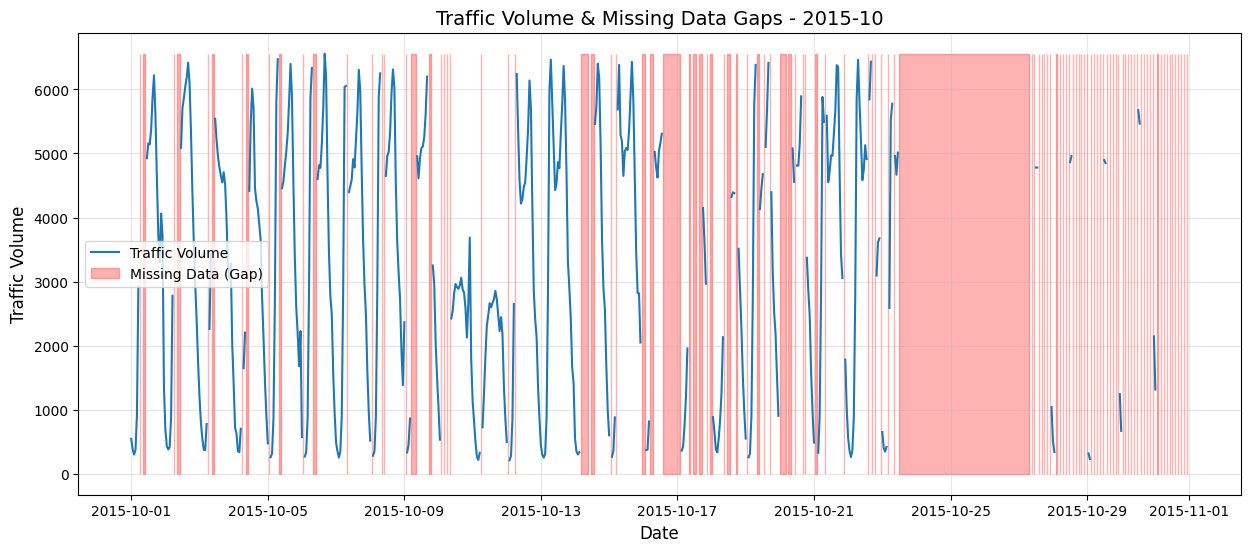

--- Analyzing: 2015-11 ---
Missing hours: 324 (45.00%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2015_11.png


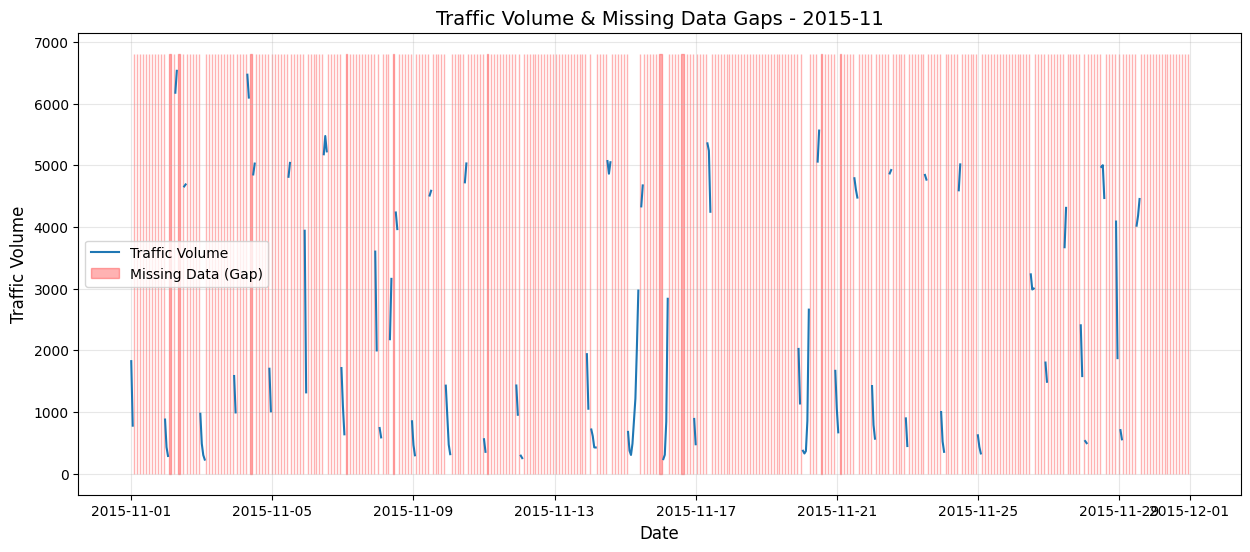

--- Analyzing: 2015-12 ---
Missing hours: 305 (40.99%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2015_12.png


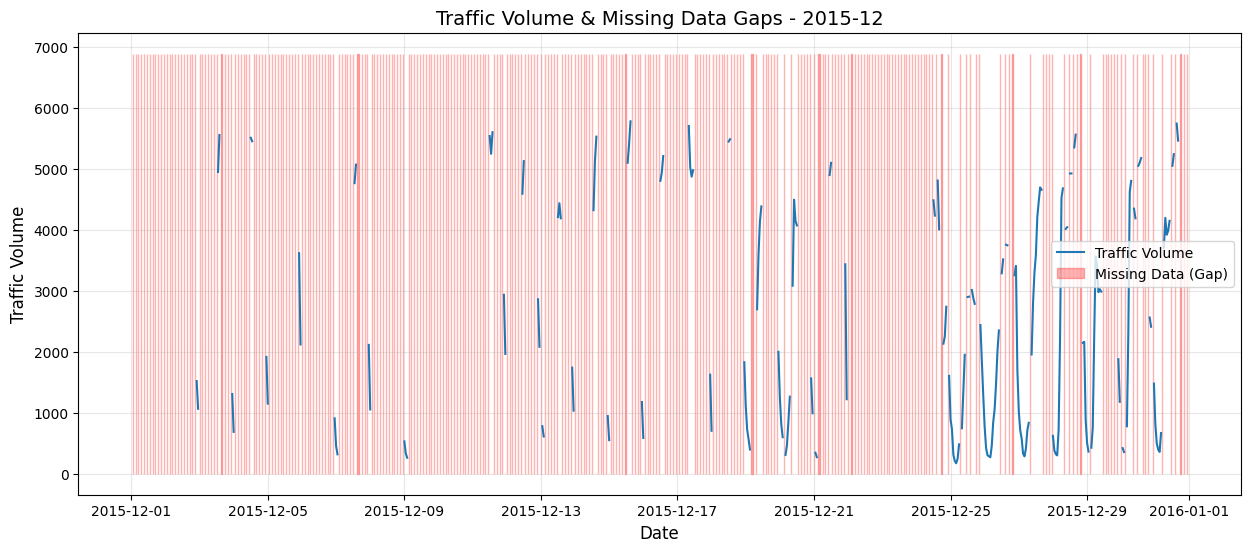

--- Analyzing: 2016-01 ---
Missing hours: 283 (38.04%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2016_01.png


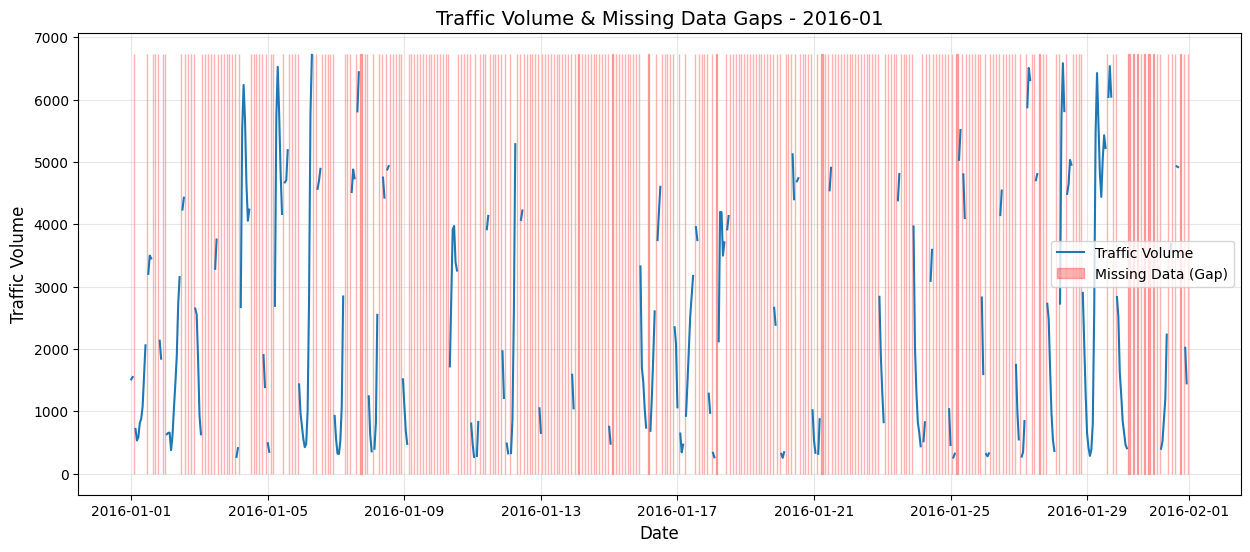

--- Analyzing: 2016-02 ---
Missing hours: 187 (26.87%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2016_02.png


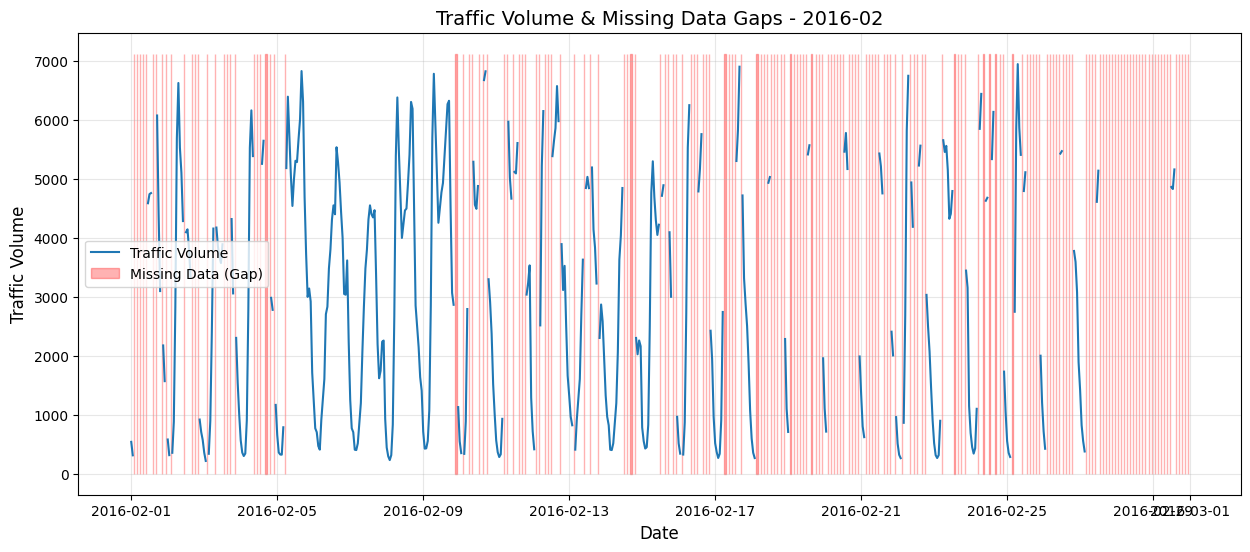

--- Analyzing: 2016-03 ---
Missing hours: 272 (36.56%)
Plot saved at: ../images/01-exploration/missing_data_gaps/missing_gaps_2016_03.png


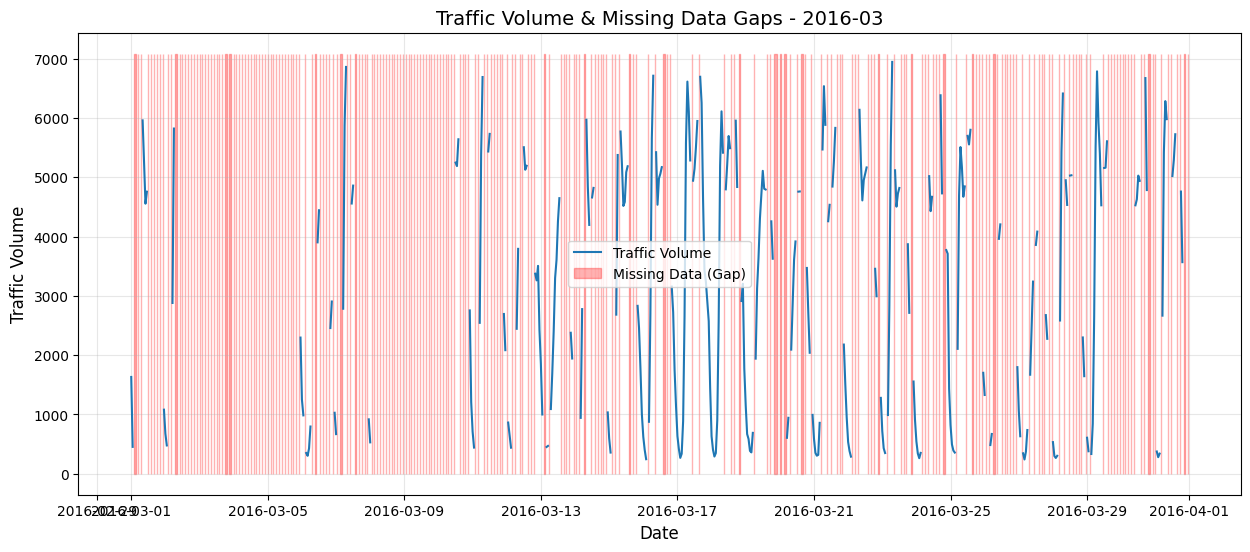

In [13]:
import calendar
import os

def plot_traffic_gaps(df, year, month, save_path=None):
    """
    Plots traffic volume for a specific month to visualize missing data gaps.
    Optional: Saves the plot if save_path is provided.
    """
    
    _, num_days = calendar.monthrange(year, month)
    start_date = f"{year}-{month:02d}-01 00:00:00"
    end_date = f"{year}-{month:02d}-{num_days} 23:00:00"
    full_range = pd.date_range(start=start_date, end=end_date, freq='h')
    subset = df.loc[start_date:end_date].reindex(full_range)
    
    total_hours = len(full_range)
    missing_hours = subset['traffic_volume'].isna().sum()
    missing_pct = (missing_hours / total_hours) * 100
    
    print(f"--- Analyzing: {year}-{month:02d} ---")
    print(f"Missing hours: {missing_hours} ({missing_pct:.2f}%)")
    
    # 3. Plotting
    plt.figure(figsize=(15, 6))
    
    plt.plot(subset.index, subset['traffic_volume'], label='Traffic Volume', color='tab:blue')
    
    missing_mask = subset['traffic_volume'].isna()
    plt.fill_between(subset.index, 0, subset['traffic_volume'].max(), 
                     where=missing_mask, color='red', alpha=0.3, label='Missing Data (Gap)')
    
    plt.title(f"Traffic Volume & Missing Data Gaps - {year}-{month:02d}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Traffic Volume", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved at: {save_path}")
        
    plt.show()

# --- Execution for the suspect periods ---

print("\n--- Plotting Gaps for Months to Investigate ---")

for (year, month), pct in months_to_investigate.items():
    # Define the image path
    caminho_imagem = f'../images/01-exploration/missing_data_gaps/missing_gaps_{year}_{month:02d}.png'
    plot_traffic_gaps(df, year, month, save_path=caminho_imagem)

### Gap Size Analysis and Imputation Strategy

--- Summary of Missing Data Gap Sizes ---
count    2588.000000
mean        4.627512
std       145.299803
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      7386.000000
Name: gap_size_hours, dtype: float64

--- Distribution of Gap Sizes ---
gap_size_category
1h        2192
2h         201
3-5h       109
6-12h       57
13-24h      18
>24h        11
Name: count, dtype: int64


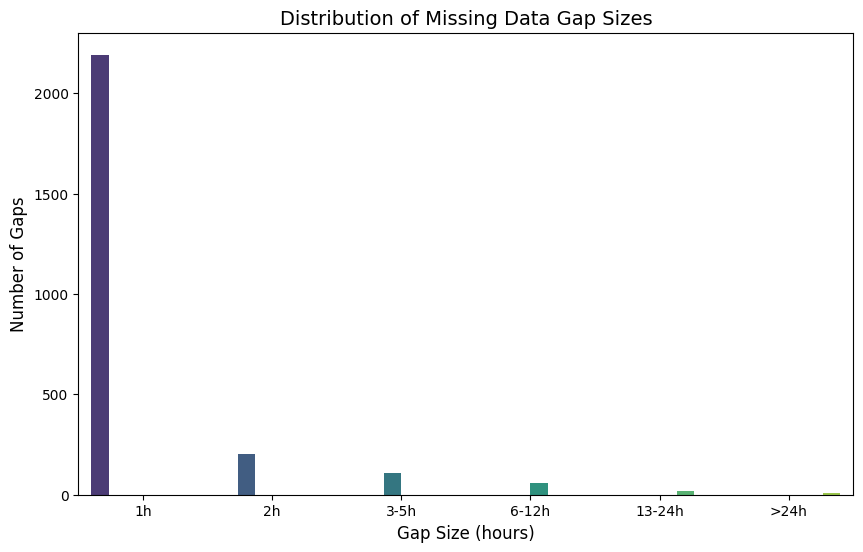

In [14]:
# --- Gap Size Analysis ---

# 1. Find the time difference between consecutive missing timestamps
#    A difference of more than 1 hour indicates the start of a new gap.
time_diffs = missing_dates_agg.to_series().diff()

# 2. Identify the start of each new gap
#    A new gap starts where the time difference is greater than 1 hour.
#    The first timestamp is also the start of a gap.
gap_starts = time_diffs[time_diffs > pd.Timedelta('1 hour')].index
all_gap_starts = missing_dates_agg.union(gap_starts) # Ensure all starts are included

# 3. Group consecutive timestamps into gaps
gaps = []
current_gap = []
if not missing_dates_agg.empty:
    current_gap.append(missing_dates_agg[0])
    for i in range(1, len(missing_dates_agg)):
        if (missing_dates_agg[i] - missing_dates_agg[i-1]) > pd.Timedelta('1 hour'):
            gaps.append(current_gap)
            current_gap = []
        current_gap.append(missing_dates_agg[i])
    gaps.append(current_gap) # Add the last gap

# 4. Calculate the size (in hours) of each gap
gap_sizes_hours = [len(gap) for gap in gaps]

# 5. Create a DataFrame for easier analysis
df_gaps = pd.DataFrame({'gap_size_hours': gap_sizes_hours})

# --- Summary of Gap Sizes ---
print("--- Summary of Missing Data Gap Sizes ---")
print(df_gaps['gap_size_hours'].describe())

# --- Distribution of Gap Sizes ---
# Let's see how many gaps are small vs. large.
# Bins: 1h, 2h, 3-5h, 6-12h, 13-24h, >24h
bins = [0, 1, 2, 5, 12, 24, float('inf')]
labels = ['1h', '2h', '3-5h', '6-12h', '13-24h', '>24h']
df_gaps['gap_size_category'] = pd.cut(df_gaps['gap_size_hours'], bins=bins, labels=labels, right=True)

gap_distribution = df_gaps['gap_size_category'].value_counts().sort_index()

print("\n--- Distribution of Gap Sizes ---")
print(gap_distribution)

# --- Plotting the Distribution ---
plt.figure(figsize=(10, 6))
sns.barplot(x=gap_distribution.index, y=gap_distribution.values, hue=gap_distribution.index, palette='viridis', legend=False)
plt.title('Distribution of Missing Data Gap Sizes', fontsize=14)
plt.xlabel('Gap Size (hours)', fontsize=12)
plt.ylabel('Number of Gaps', fontsize=12)
plt.show()

The analysis above categorizes the missing data into continuous gaps and analyzes their sizes. This is crucial for deciding on an imputation strategy.

**Findings:**
*   **Many Small Gaps:** The distribution shows a large number of very small gaps (1-2 hours).
*   **Fewer Large Gaps:** There are progressively fewer gaps as the size increases.
**Proposed Strategy:**
1.  **Impute Small Gaps (<= 2 hours):** Gaps of 1 or 2 hours are small enough that imputation (e.g., using the mean of the surrounding values or a more sophisticated method like seasonal decomposition) is a reasonable approach. This will fill in minor holes in the data without introducing significant bias.
2.  **Discard Data for Large Gaps (> 2 hours):** For larger gaps, imputation becomes risky. The traffic patterns over several hours can be complex (e.g., rush hour peaks, nighttime lulls), and simply filling them in with a simple metric could distort the data. Therefore, for any gap larger than 2 hours, it is safer to treat that period as missing and not use it for training models that require continuous data. This might mean dropping the data around these gaps or splitting the dataset into multiple continuous segments.
This two-pronged approach allows us to retain as much data as possible by filling in minor gaps while avoiding the introduction of synthetic and potentially misleading data for longer and more significant periods of missing observations. The implementation of this strategy will be handled in the data preprocessing.

# 4. Exploratory Data Analysis (EDA)

## Univariate Analysis

### Numeric Variables Analysis 

#### Analysis of 'temp'

--- Analysis of 'temp' ---
count    40575.000000
mean       281.315882
std         13.817217
min          0.000000
25%        271.840000
50%        282.860000
75%        292.280000
max        310.070000
Name: temp, dtype: float64


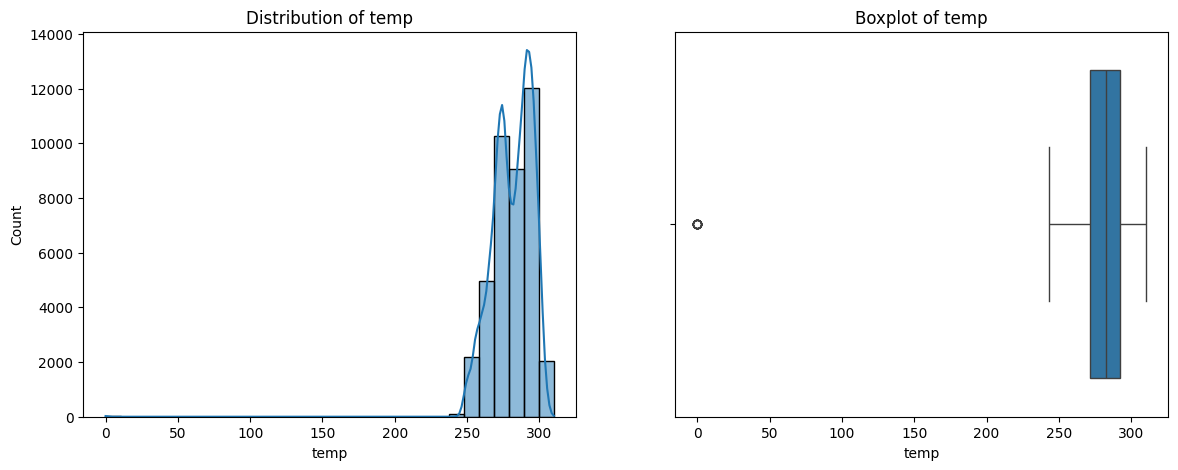

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis of 'temp'  
print("--- Analysis of 'temp' ---")
print(df['temp'].describe())
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['temp'], kde=True, bins=30)
plt.title('Distribution of temp')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['temp'])
plt.title('Boxplot of temp')
plt.show()

**Analysis of the descriptive statistics and graphs of the `temp` variable revealed the following points:**

1. **Central Tendency and Dispersion**
   - The mean temperature is **281.32 K** (approx. **8°C**) with a standard deviation of **13.82**
   - This indicates data variability around the mean

2. **Distribution**
   - The histogram shows an **approximately normal distribution**
   - Data is concentrated between **250 K** and **300 K**

3. **Detected Anomaly (Outlier)**
   - The minimum recorded value is **0 K**
   - Visually, the **Boxplot** confirms this value as an **isolated extreme outlier**

4. **⚠️ CRUCIAL DECISION POINT: Conclusion & Action Required**
   - **Key Finding:** The recorded value of **0 Kelvin (absolute zero)** is **physically impossible** in the context of ambient temperature
   - **Interpretation:** This record definitively represents **sensor noise or measurement error**
   - **🔴 CRITICAL ACTION:** **This data point MUST be treated (filtered/removed) before any modeling to avoid significant bias in results**

If we need to visualize the real distribution of the `temp` variable without the outlier, we can filter out the 0 K value and re-plot the histogram and boxplot. This will provide a clearer picture of the temperature distribution in the dataset. 

--- Analysis of 'temp' without outlier (0 K) ---
count    40565.000000
mean       281.385232
std         13.093822
min        243.390000
25%        271.840000
50%        282.865000
75%        292.280000
max        310.070000
Name: temp, dtype: float64


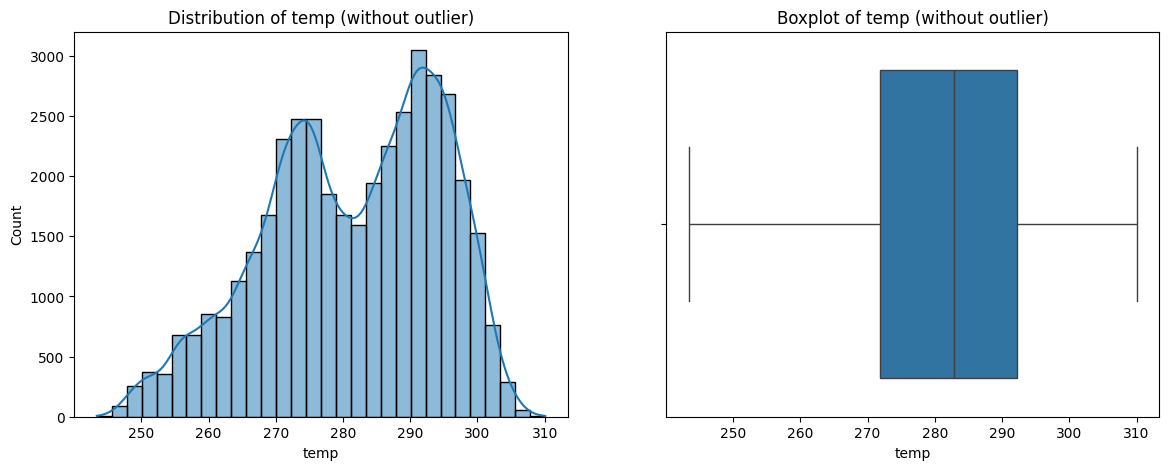

<Figure size 640x480 with 0 Axes>

In [28]:
# If we need to visualize the real distribution of the `temp` variable without the outlier, we can filter out the 0 K value and re-plot the histogram and boxplot. This will provide a clearer picture of the temperature distribution in the dataset. 
df = df[df['temp'] > 0].copy()  # Use .copy() to avoid SettingWithCopyWarning
print("--- Analysis of 'temp' without outlier (0 K) ---")
print(df['temp'].describe())
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['temp'], kde=True, bins=30)
plt.title('Distribution of temp (without outlier)')

# Boxplot without outlier
plt.subplot(1, 2, 2)
sns.boxplot(x=df['temp'])
plt.title('Boxplot of temp (without outlier)')
plt.show()

# code to save the image of the temp distribution without duplicates
import os
os.makedirs('../images/univariate_analysis/', exist_ok=True)
plt.savefig('../images/univariate_analysis/temp_distribution.png')

Now, it's possible to visualize the distribution of the `temp` variable without the outlier, providing a clearer picture of the temperature distribution in the dataset.

#### Analysis of 'rain_1h'

--- Analysis of 'rain_1h' ---
count    40565.000000
mean         0.318708
std         48.818656
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9831.300000
Name: rain_1h, dtype: float64


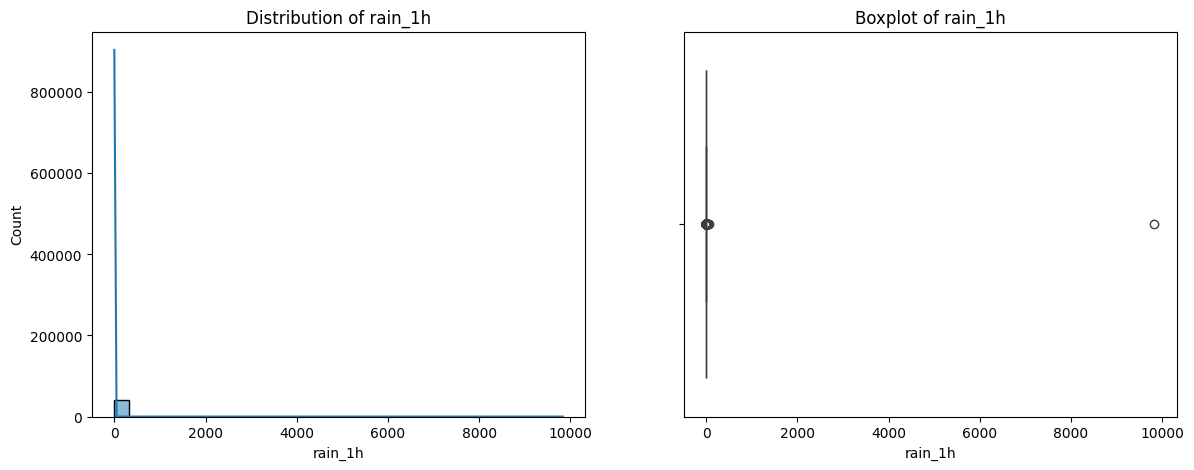

In [29]:
# Analysis of 'rain_1h'  
print("--- Analysis of 'rain_1h' ---")
print(df['rain_1h'].describe())
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['rain_1h'], kde=True, bins=30)
plt.title('Distribution of rain_1h')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['rain_1h'])
plt.title('Boxplot of rain_1h')
plt.show()

There is a outlier in the 'rain_1h' variable with a value of 9831.3 mm, which is extremely high and likely represents a data error or anomaly.

**⚠️ CRUCIAL DECISION POINT: Because of this, we need to treat this outlier before modeling.**

We will verify if there is values above 100mm (which is already a very high value for hourly rainfall).

In [18]:
# We will verify if there is values above 100mm (which is already a very high value for hourly rainfall), excepting the known outlier of 9831.3 mm.
outliers_rain = df[(df['rain_1h'] > 100) & (df['rain_1h'] != 9831.3)]
print(f"Amount of records with rain_1h > 100mm: {len(outliers_rain)}")
print(outliers_rain.sort_values(by='rain_1h', ascending=False))



Amount of records with rain_1h > 100mm: 0
Empty DataFrame
Columns: [temp, rain_1h, snow_1h, clouds_all, traffic_volume, holiday, weather_main, weather_description]
Index: []


There are no values above 100mm in the 'rain_1h' variable, except for the outlier of 9831.3 mm. Now, we can visualize the distribution of 'rain_1h' without the outlier to better understand its typical range.

--- Analysis of 'rain_1h' without outlier (9831.3 mm) ---
count    40574.000000
mean         0.076332
std          0.769622
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.630000
Name: rain_1h, dtype: float64


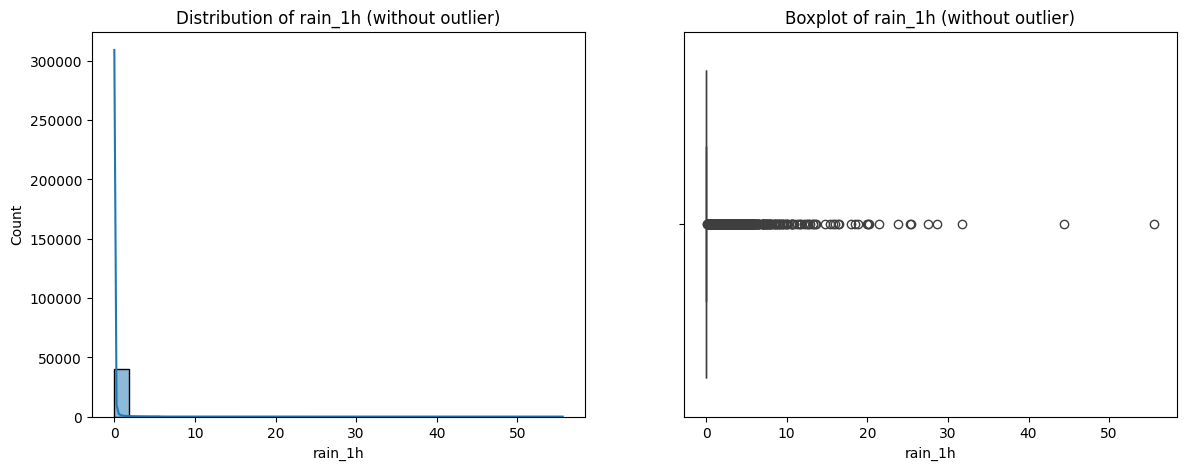

In [19]:
# There are no values above 100mm in the 'rain_1h' variable, except for the outlier of 9831.3 mm. Now, we can visualize the distribution of 'rain_1h' without the outlier to better understand its typical range.
df_rain_filtered = df[df['rain_1h'] < 100]
print("--- Analysis of 'rain_1h' without outlier (9831.3 mm) ---")
print(df_rain_filtered['rain_1h'].describe())
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_rain_filtered['rain_1h'], kde=True, bins=30)
plt.title('Distribution of rain_1h (without outlier)')
# Boxplot without outlier
plt.subplot(1, 2, 2)
sns.boxplot(x=df_rain_filtered['rain_1h'])
plt.title('Boxplot of rain_1h (without outlier)')
plt.show()

After removing the extreme outlier (impossible value of ~9831 mm), the analysis of the `rain_1h` variable reveals a distribution highly concentrated at zero (no rain), characteristic of sporadic meteorological phenomena.

**Key Observations:**

1.  **Predominance of Zeros (Sparsity):**
    * Descriptive statistics indicate that the **minimum**, **25% (Q1)**, **50% (Median)**, and **75% (Q3)** are all equal to `0.00`.
    * This means that in **more than 75% of the recorded hours**, there was no precipitation. The variable is "zero-inflated".

2.  **Skewness:**
    * The distribution is **strongly right-skewed**.
    * The mean (`0.076`) is higher than the median (`0.0`), pulled by extreme rain values, but it is still a low value due to the large number of zeros.

3.  **Outlier Analysis (Boxplot):**
    * The *Boxplot* appears "collapsed" at zero because the Interquartile Range (IQR) is 0.
    * All values where `rain_1h > 0` are visually plotted as *outliers* (the circles in the chart). However, the maximum value of **55.63 mm** (classified as *Violent Rain*) is a plausible meteorological data point for severe storms, representing an extreme event ("Natural Outlier") and not necessarily a measurement error.

**Conclusion for Modeling:**
Due to high sparsity, this variable may have little predictive power in its pure continuous form for linear models (which assume normality). It may be beneficial to test:
* A binary transformation (e.g., `is_raining`: 0 or 1).
* A categorization (e.g., No Rain, Light Rain, Heavy Rain) that is more interpretable and may capture non-linear relationships with traffic volume. For example, a light rain could have a different impact on traffic than heavy rain, and this categorization could help capture those nuances in the model.

#### Analysis of 'snow_1h'

--- Analysis of 'snow_1h' ---
count    40575.000000
mean         0.000117
std          0.005676
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.510000
Name: snow_1h, dtype: float64


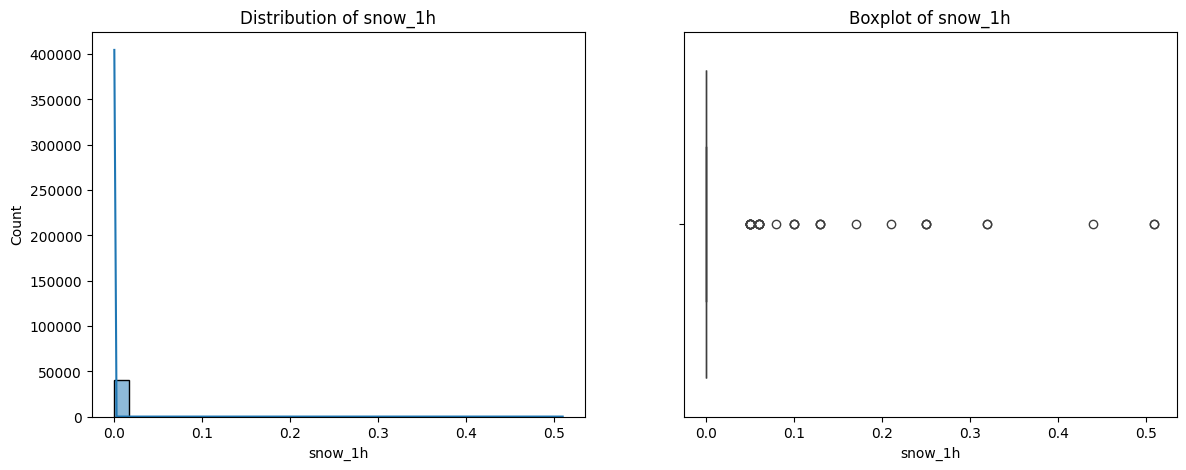

In [20]:
# Analysis of 'snow_1h'  
print("--- Analysis of 'snow_1h' ---")
print(df['snow_1h'].describe())
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['snow_1h'], kde=True, bins=30)
plt.title('Distribution of snow_1h')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['snow_1h'])
plt.title('Boxplot of snow_1h')
plt.show()

The analysis of the `snow_1h` variable reveals a distribution that is **extremely sparse**, even more so than the rain data. The values are heavily concentrated at zero with very low magnitude variations when positive.

**Key Observations:**

1.  **Extreme Sparsity (Zero-Inflation):**
    * Similar to the rain data, the **minimum**, **25%**, **50%**, and **75%** quartiles are all `0.00`.
    * The mean (`0.000117`) is exceedingly close to zero. This indicates that snowfall (as a measured quantity) is a rare event in this dataset, or often recorded as 0 even when present (trace amounts).

2.  **Low Magnitude of Values:**
    * Unlike the rain variable (which reached ~55 mm), the **maximum value** for snow is only **0.51 mm**.
    * This suggests that the variable likely represents the **liquid equivalent** of snow (melted) or that significant snowfall accumulation is rarely captured in this specific column. The range of data (0.0 to 0.51) is extremely narrow.

3.  **Distribution Structure:**
    * **Skewness:** The distribution is heavily right-skewed.
    * **Boxplot Analysis:** The boxplot is completely "collapsed" at zero. The "outliers" (circles) represent the rare instances where any snow was recorded. Since the maximum is so low (0.51), these are statistically outliers relative to the massive number of zeros, but physically they represent very light precipitation.

**Conclusion for Modeling:**
The `snow_1h` feature in its current continuous form is **quasi-constant** (near-zero variance). It carries very little information as a numerical value because the magnitude (0 to 0.51) is negligible.
* **Decision:** This feature will not be used as a continuous variable in regression models, as it will likely have a coefficient of near zero.
* **Feature Engineering:** It is convenient to convert this to a binary feature (`is_snowing`: 0 or 1) or validate it against the categorical `weather_description` column to see if snow events are being captured there instead of in this numerical column. This validation will be performed in the next section (Data Quality Check) of this notebook.

### Categorical Variables Analysis


--- Analysis of holiday ---
holiday
Columbus Day                 5
Veterans Day                 5
Thanksgiving Day             5
Christmas Day                5
New Years Day                5
Washingtons Birthday         5
Memorial Day                 5
Independence Day             5
State Fair                   5
Labor Day                    5
Martin Luther King Jr Day    3
Name: count, dtype: int64


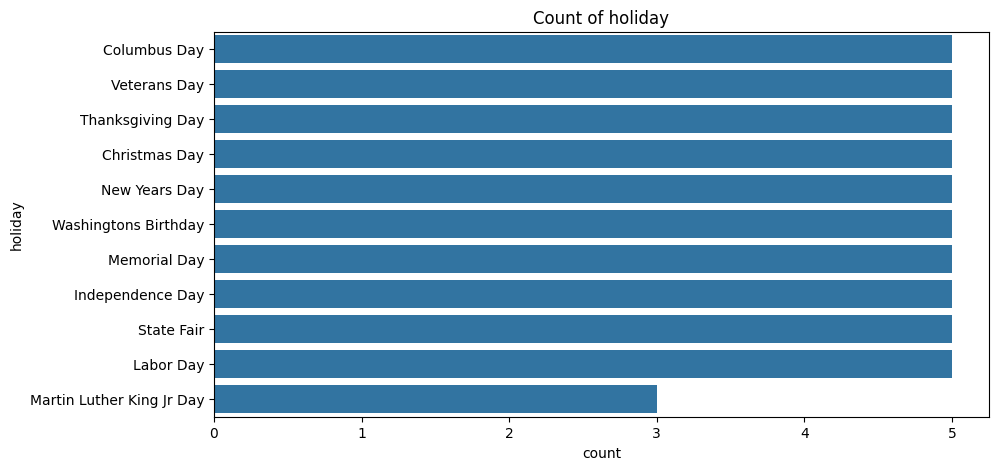


--- Analysis of weather_main ---
weather_main
Clouds          15123
Clear           13366
Rain             4769
Mist             3069
Snow             2297
Haze              766
Drizzle           515
Thunderstorm      453
Fog               201
Smoke              15
Squall              1
Name: count, dtype: int64


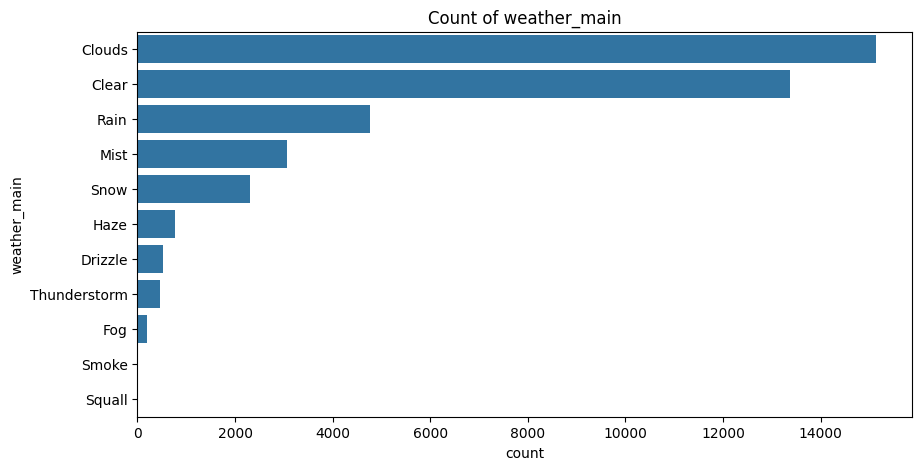

In [21]:
# --- Categorical Variables Analysis ---
categorical_vars = ['holiday', 'weather_main']

for var in categorical_vars:
    print(f"\n--- Analysis of {var} ---")
    print(df[var].value_counts())
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[var], order=df[var].value_counts().index)
    plt.title(f'Count of {var}')
    plt.show()

**Analysis of 'holiday' Variable**

* The 'holiday' variable contains categorical data indicating whether a given date is a holiday or not, and specifies the name of the holiday.
* There are 61 non-null entries in this column, indicating that only a small portion of the dataset corresponds to holidays.
* The majority of the entries in the 'holiday' column are null, suggesting that most dates in the dataset are regular days without holidays.
* For modeling purposes, it will be beneficial to create a binary feature indicating whether a date is a holiday or not, treating null values as non-holidays.

**Analysis of 'weather_main' Variable**

* The 'weather_main' variable provides categorical descriptions of the primary weather conditions during each observation.
* The most frequently occurring weather condition is 'Clouds', followed by 'Clear', 'Rain', and 'Mist'.
* Less common weather conditions include 'Snow', 'Fog', 'Haze', 'Thunderstorm', and 'Drizzle'.
* For modeling, it may be useful to group less frequent weather conditions into an 'Other' category to reduce the number of categories and avoid sparsity issues. And, we can discard the categorical levels that are inexistent in the dataset.

## Data Quality Check

### Analysis of 'snow_1h' Variable Quality

In this topic, we will investigate the quality of the `snow_1h` variable by cross-referencing it with the `weather_description` categorical variable to identify any inconsistencies or potential measurement errors. 

In [22]:
# Cross-referencing snow_1h with weather_description to investigate data quality

# Case 1: snow_1h > 0 but weather_description does not indicate snow
snow_but_no_snow_description = df[(df['snow_1h'] > 0) & (~df['weather_description'].str.contains('snow', case=False))]

# Case 2: weather_description indicates snow but snow_1h is 0
snow_description_but_no_snow = df[(df['weather_description'].str.contains('snow', case=False)) & (df['snow_1h'] == 0)]

print("--- Data Quality Check for snow_1h ---")
print(f"Number of records with snow > 0 but no 'snow' in description: {len(snow_but_no_snow_description)}")
if not snow_but_no_snow_description.empty:
    print("Examples:")
    print(snow_but_no_snow_description.head())

print("\n" + "-"*50 + "\n")

print(f"Number of records with 'snow' in description but snow_1h is 0: {len(snow_description_but_no_snow)}")
if not snow_description_but_no_snow.empty:
    print("Examples:")
    print(snow_description_but_no_snow.head())

--- Data Quality Check for snow_1h ---
Number of records with snow > 0 but no 'snow' in description: 1
Examples:
                       temp  rain_1h  snow_1h  clouds_all  traffic_volume  \
date_time                                                                   
2015-12-23 12:00:00  274.33     0.98     0.51        90.0          5167.0   

                    holiday weather_main weather_description  
date_time                                                     
2015-12-23 12:00:00     NaN         Rain       moderate rain  

--------------------------------------------------

Number of records with 'snow' in description but snow_1h is 0: 2264
Examples:
                       temp  rain_1h  snow_1h  clouds_all  traffic_volume  \
date_time                                                                   
2012-10-26 13:00:00  275.01      0.0      0.0        90.0          5874.0   
2012-10-26 14:00:00  275.38      0.0      0.0        90.0          5879.0   
2012-10-26 15:00:00  275.85

***Reliability Check: Snow Volume vs. Description***

We observed a major discrepancy between the sensor data and the weather description:

* **False Zeros:** In 2,264 cases, the description explicitly states conditions like "heavy snow", yet `snow_1h` reports 0. This suggests a systematic issue with the snow sensor or data logging during these events.
* **Noise:** There is only 1 instance of `snow_1h > 0` without a corresponding snow description, which is negligible.

**Decision:** Due to the high volume of "silent failures" (zeros during snow events), the `snow_1h` variable should be considered **low quality**. For modeling, deriving features from `weather_description` (e.g., `is_snowing`) will be more robust than using the raw `snow_1h` values.

## Time Series Visualization

In this section, we will visualize the time series data to identify trends, seasonal patterns, and any anomalies in the traffic volume over time. This will help us understand the temporal dynamics of the dataset and inform our modeling approach.

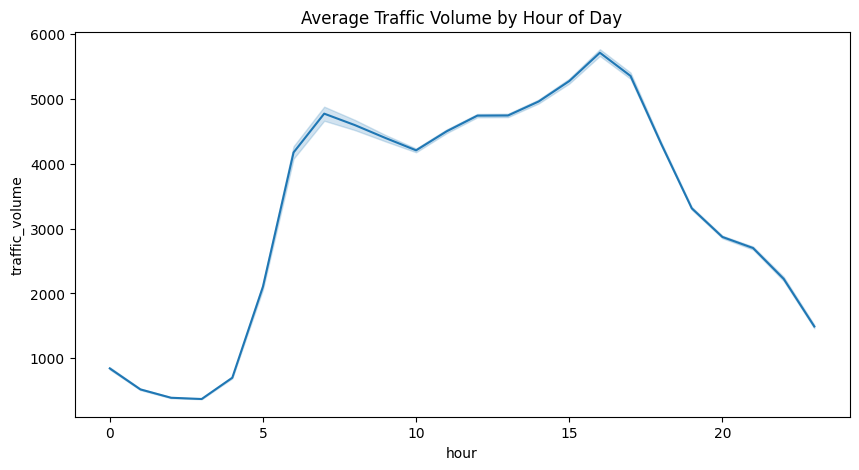

In [23]:
# Create temporary features for visualization
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

# Plot average traffic volume by hour
plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='traffic_volume', data=df)
plt.title('Average Traffic Volume by Hour of Day')
plt.show()

**Visualizing Traffic Volume by Hour of the Day**

By analyzing the average traffic volume per hour, we observe a clear bimodal distribution:

* Rush Hours: There are two distinct peaks in traffic volume, one in the morning (around 7-9 AM) and another in the evening (around 3-6 PM). This pattern aligns with typical commuting times, indicating higher traffic during these periods.
* Business Hours: Traffic remains relatively high during the day (between the peaks).
* Low Nighttime Traffic: Traffic volume drops significantly during nighttime hours (10 PM to 5 AM), reflecting reduced activity during these times.

*Conclusion*: The hour of the day is a strong predictor of traffic volume.




## Correlation/Bivariate Analysis

### Numeric x Numeric Analysis

**Scatter plot for temperature x traffic_volume**

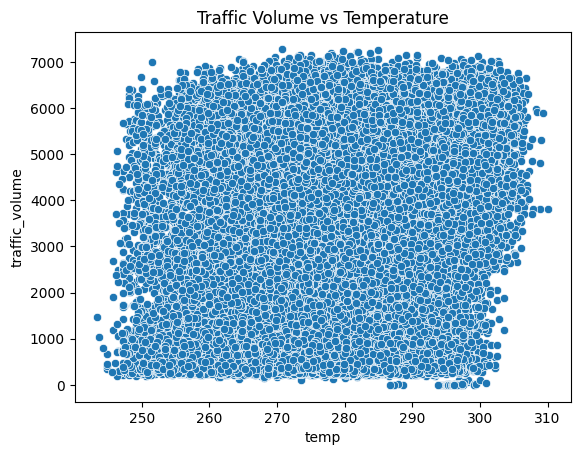

0.13688415439118015


In [24]:
# Filtering the dataframe to temperature there are > 0 
df_without_outlier = df[df['temp'] > 0]

# Scatter plot for temperature x traffic_volume
sns.scatterplot(x='temp', y='traffic_volume', data=df_without_outlier)
plt.title('Traffic Volume vs Temperature')
plt.show()
print(df['traffic_volume'].corr(df['temp']))

Apparently, there is no correlation between temperature and traffic volume. The correlation coefficient is very close to zero.

**Correlation Matrix and Heatmap**

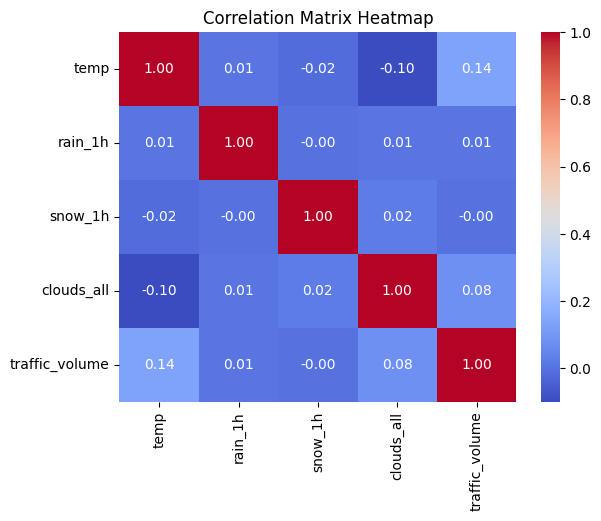

In [25]:
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure
sns.heatmap(corr_matrix, annot =True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

### Categorical x Numeric Analysis



**Box Plot of Traffic Volume by Weather Conditions**

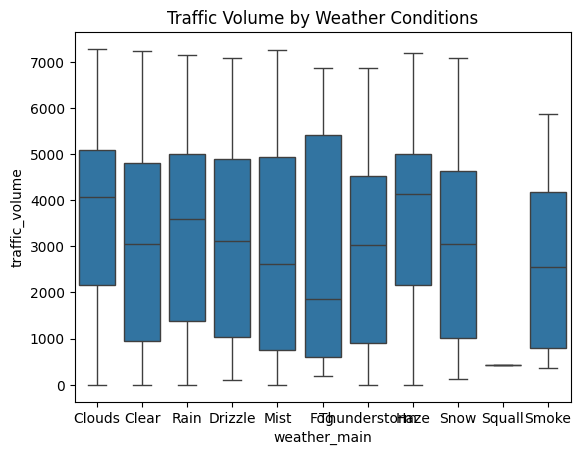

In [26]:
sns.boxplot(data=df, x='weather_main', y='traffic_volume')
plt.title('Traffic Volume by Weather Conditions')
plt.show()

After analyzing the box plots of traffic volume by weather conditions, we can notice that is not some aparent relationship between weather and traffic volume. To make sure of this, let's filter only diurnal observations (6 AM to 8 PM) and re-plot the box plots.

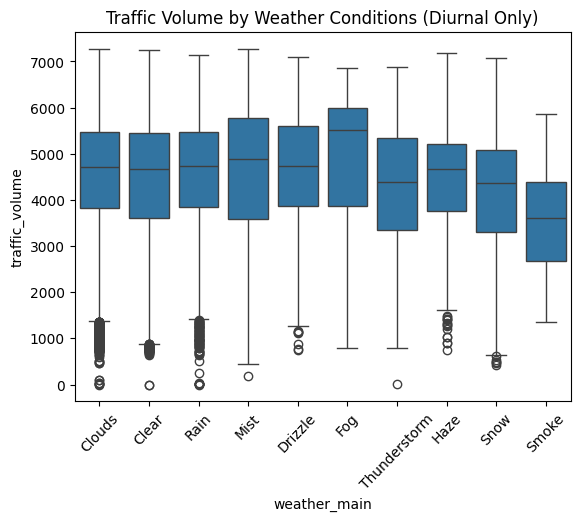

In [27]:
df_diurnal = df.between_time('06:00', '20:00')
sns.boxplot(data=df_diurnal, x='weather_main', y='traffic_volume')
plt.xticks(rotation=46) # to rotate x-axis labels for better readability
plt.title('Traffic Volume by Weather Conditions (Diurnal Only)')
plt.show()